### Mont Drive from Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import libraries

In [2]:
import pandas as pd
import numpy as np

# importations functions from machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# used from transform class model from machine learning in physical file
from sklearn.externals import joblib

# libraries from plot graphs
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly

# libraries from format same tables (focus in confusion matrix)
from tkinter import font
import seaborn

# libraries from configuration basic of loggers
import logging
import sys

# libraries from msg warning mensages, in this case, from ignore all
import warnings
warnings.filterwarnings('ignore')

## functions about head in pandas, this case otimized display from same lines anda width columns
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 10)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### logs info

In [0]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO, 
                     format='%(asctime)s;%(levelname)s;%(message)s',
                     datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger('Text_process')

### Maps from directorys

In [0]:
datalake="/content/drive/My Drive/datasets/app_bank/datalake"
transient=f"{datalake}/transient"
raw=f"{datalake}/raw"
trusted=f"{datalake}/trusted"
refined=f"{datalake}/refined"
rules=f"{datalake}/rules"
model_dir = f'{datalake}/model_dir'
save_fil = f'{datalake}/save_file'

### Functions of transformation

In [0]:
# function for transformation text in features, this case i'am transform column job in features from logistic regression model
def transformVectorize(df,x,categories):
    df_features = df[f"{x}"].values
    df_categories = df[f"{categories}"].values

    vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False)
    features = vectorizer.fit_transform(df_features)
    
    return features,df_categories

# i'am using logistic regression model because i prefer work with variables categories
def modelLogistcRegression(df,fet,category,filename):
    
    x_train,x_test,y_train,y_test = train_test_split(fet,category,test_size=0.3, random_state=42)

    classifer = LogisticRegression(n_jobs=1,class_weight='balanced', solver='lbfgs',max_iter=30,multi_class='ovr')
    model = classifer.fit(x_train,y_train)
    
    #Save model
    file_model = f'{model_dir}/model_pip_app_bk_{filename}.joblib' 
    joblib.dump(model, file_model)    
    
    return x_train,x_test,y_train,y_test,model

# recovery file model from logistic regression because is more fast to read
def recoveryLogistcRegression(filename):

  file_model = f'{model_dir}/model_pip_app_bk_{filename}.joblib'  
  model_loader = joblib.load(file_model)

  return model_loader

# confusion matrix for avaliable the precision of model
def confusionMatrix(x,y,model):
  conf_mat = confusion_matrix(x, y)
  fig, ax = plt.subplots(figsize=(6,6))
  seaborn.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
              xticklabels=model.classes_, 
              yticklabels=model.classes_)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title("CONFUSION MATRIX - Logistic Regression \n", size=12);

### Load from CSV dataset

In [6]:
df = pd.read_csv(f'{transient}/bank-full.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
df_jobs = df.groupby(['job']).count()
df_jobs

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
job,,,,,,,,,,,,,,,,
admin.,5171,5171,5171,5171,5171,5171,5171,5171,5171,5171,5171,5171,5171,5171,5171,5171
blue-collar,9732,9732,9732,9732,9732,9732,9732,9732,9732,9732,9732,9732,9732,9732,9732,9732
entrepreneur,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487,1487
housemaid,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240
management,9458,9458,9458,9458,9458,9458,9458,9458,9458,9458,9458,9458,9458,9458,9458,9458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
services,4154,4154,4154,4154,4154,4154,4154,4154,4154,4154,4154,4154,4154,4154,4154,4154
student,938,938,938,938,938,938,938,938,938,938,938,938,938,938,938,938
technician,7597,7597,7597,7597,7597,7597,7597,7597,7597,7597,7597,7597,7597,7597,7597,7597


In [9]:
print(df.job.value_counts())

blue-collar     9732
management      9458
technician      7597
admin.          5171
services        4154
                ... 
entrepreneur    1487
unemployed      1303
housemaid       1240
student         938 
unknown         288 
Name: job, Length: 12, dtype: int64


#### 1) Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

In [10]:
# select distinct values from column job
print(df.job.nunique())

12


### Creating model from Machine Learning Logistic Regression

##### transform jobs in features from model ML

In [11]:
features,category = transformVectorize(df,'job','loan')
features.shape
features[:3].toarray()

array([[0.        , 0.        , 0.38936746, 0.        , 0.        ,
        0.        , 0.33577004, 0.        , 0.38144089, 0.        ,
        0.        , 0.        , 0.        , 0.55929943, 0.45931342,
        0.        , 0.        , 0.        , 0.        , 0.25762305,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.18990902, 0.        , 0.50611364,
        0.        , 0.16376756, 0.        , 0.        , 0.38193882,
        0.52075418, 0.        , 0.        , 0.        , 0.44804853,
        0.        , 0.        , 0.        , 0.        , 0.25130472,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.49736791, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.34018484,
        0.        , 0.36758018, 0.64159867, 0.        , 0.19080535,
        0.23179455, 0.        , 0.        , 0.        ]])

##### Training model used loan from categories and jobs in features (recovery modelFile)

##### the precision in 'yes' categorie is down but recall is up, more details we see in confusion matrix

In [12]:
x_train,x_test,y_train,y_test,model = modelLogistcRegression(df,features,category,'supervisioned')
model_loader = recoveryLogistcRegression('supervisioned')
a_pred = model_loader.predict(x_test)
print(classification_report(y_test,a_pred))

              precision    recall  f1-score   support

          no       0.88      0.40      0.55     11398
         yes       0.18      0.72      0.29      2166

    accuracy                           0.45     13564
   macro avg       0.53      0.56      0.42     13564
weighted avg       0.77      0.45      0.51     13564



##### Avaliable model using Confusion Matrix

##### Avaliable the model, we see the model predict more incorrecty because the false positive the number is very large, but the false negative is more down.. we needs to calibrated model from predictions

12/13/2019 06:04:57 PM;INFO;NumExpr defaulting to 2 threads.


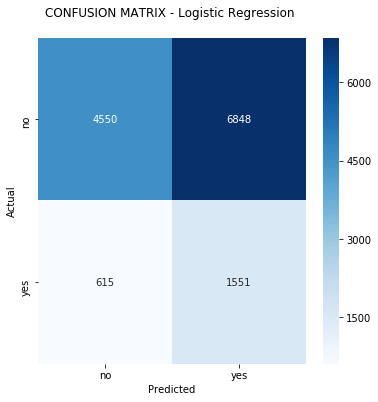

In [13]:
confusionMatrix(y_test,a_pred,model)

### Prediction in dataset (real world)

#### Using 13k predictions of model training and apply in dataset

In [14]:
pred = np.array(a_pred)
print(len(pred))

13564


In [0]:
df_novo = df.head(len(pred))
df_novo['predicao'] = a_pred

##### display from predictions in dataset

In [16]:
df_novo.head(200)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,predicao
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,yes
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,yes
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,33,blue-collar,single,secondary,no,307,yes,no,unknown,5,may,309,2,-1,0,unknown,no,yes
196,38,services,married,secondary,no,155,yes,no,unknown,5,may,248,1,-1,0,unknown,no,no
197,50,technician,divorced,tertiary,no,173,no,yes,unknown,5,may,98,1,-1,0,unknown,no,yes
198,43,management,married,tertiary,no,400,yes,no,unknown,5,may,256,1,-1,0,unknown,no,no


##### Counting jobs predictions distinct datasets because i preferer to visualize results separeted

In [17]:
df_sim = df_novo.where(df_novo['predicao']=='yes').groupby(['job'])['job'].count().sort_values(ascending=False)
df_sim.head(200)

job
blue-collar      2529
management       1246
technician       1244
admin.           982 
services         943 
                ...  
self-employed    271 
housemaid        234 
unemployed       198 
student          76  
unknown          74  
Name: job, Length: 12, dtype: int64

In [18]:
df_sim = df_novo.where(df_novo['predicao']=='no').groupby(['job'])['job'].count().sort_values(ascending=False)
df_sim.head(200)

job
blue-collar      1598
management       799 
technician       731 
admin.           617 
services         554 
                ...  
self-employed    146 
housemaid        136 
unemployed       114 
student          44  
unknown          40  
Name: job, Length: 12, dtype: int64

##### Percent predictions loan

In [19]:
df_n = df_novo.groupby(['predicao'])['predicao'].count()
df_n = df_n.transform(lambda x: x/sum(x))
df_n.head()

predicao
no     0.380787
yes    0.619213
Name: predicao, dtype: float64

##### Percent preditions details job, this case blue-collar have more probabilities in adhere to a new credit in bank

In [20]:
df_m = df_novo.groupby(['job'])['job'].count()
df_m.transform(lambda x: x/sum(x)).sort_values(ascending=False).head()

job
blue-collar    0.304261
management     0.150767
technician     0.145606
admin.         0.117886
services       0.110366
Name: job, dtype: float64

#### 2) Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

##### We see the factor of correlation and using helmap we observed the acording color the previous before campaign there more influence in result

In [21]:
df.loc[(df['poutcome']=='success')]\
.corr(method='spearman').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.17,0.016,0.11,0.029,0.0046,0.04
balance,0.17,1.0,0.028,0.019,0.089,0.0019,0.0039
day,0.016,0.028,1.0,0.019,-0.017,0.062,-0.022
duration,0.11,0.019,0.019,1.0,-0.03,0.084,0.043
campaign,0.029,0.089,-0.017,-0.03,1.0,0.056,0.11
pdays,0.0046,0.0019,0.062,0.084,0.056,1.0,-0.094
previous,0.04,0.0039,-0.022,0.043,0.11,-0.094,1.0


In [22]:
df['campaign'].loc[(df['poutcome']=='success')].corr(df['previous'],method='spearman')

0.11483052345714558

#### 3) Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão ?

##### we see the acording default metrics, the poutcome success and 'outher' demostrated potencial in maximizated accession because the numbers min and max is not large (mean = 1.8 success, other = 2.46 and min 1.0  for both and max between 11.0 and 16.0)

In [23]:
df.groupby(['poutcome'])['campaign'].describe().head()

,count,mean,std,min,25%,50%,75%,max
poutcome,,,,,,,,
failure,4901.0,1.980820,1.470818,1.0,1.0,1.0,2.0,15.0
other,1840.0,2.461413,1.902641,1.0,1.0,2.0,3.0,16.0
success,1511.0,1.806089,1.269141,1.0,1.0,1.0,2.0,11.0
unknown,36959.0,2.921886,3.325601,1.0,1.0,2.0,3.0,63.0


#### 4) O resultado da campanha anterior tem relevância na campanha atual?

#### Result positive because the acording helpmap we observed to the focus in previous and pdays can modify the actual scenarie

In [24]:
df.corr(method='spearman').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.096,-0.0089,-0.033,0.037,-0.017,-0.012
balance,0.096,1.0,0.0013,0.043,-0.031,0.07,0.08
day,-0.0089,0.0013,1.0,-0.058,0.14,-0.092,-0.088
duration,-0.033,0.043,-0.058,1.0,-0.11,0.029,0.031
campaign,0.037,-0.031,0.14,-0.11,1.0,-0.11,-0.11
pdays,-0.017,0.07,-0.092,0.029,-0.11,1.0,0.99
previous,-0.012,0.08,-0.088,0.031,-0.11,0.99,1.0


In [25]:
df['previous'].corr(df['pdays'])

0.4548196354805008

#### 5) Qual o fator determinante para que o banco exija um seguro de crédito?

##### We observed to between age and balance have more weight the factor predominant and no significant changes occur regarding the campaign

In [26]:
df.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.098,-0.0091,-0.0046,0.0048,-0.024,0.0013
balance,0.098,1.0,0.0045,0.022,-0.015,0.0034,0.017
day,-0.0091,0.0045,1.0,-0.03,0.16,-0.093,-0.052
duration,-0.0046,0.022,-0.03,1.0,-0.085,-0.0016,0.0012
campaign,0.0048,-0.015,0.16,-0.085,1.0,-0.089,-0.033
pdays,-0.024,0.0034,-0.093,-0.0016,-0.089,1.0,0.45
previous,0.0013,0.017,-0.052,0.0012,-0.033,0.45,1.0


In [27]:
df.loc[(df['housing']=='no') & (df['loan']=='no')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.095,-0.014,0.044,-0.0064,0.0024,0.011
balance,0.095,1.0,-0.029,0.028,-0.014,0.032,0.034
day,-0.014,-0.029,1.0,-0.035,0.2,-0.052,-0.051
duration,0.044,0.028,-0.035,1.0,-0.092,0.045,0.045
campaign,-0.0064,-0.014,0.2,-0.092,1.0,-0.11,-0.069
pdays,0.0024,0.032,-0.052,0.045,-0.11,1.0,0.54
previous,0.011,0.034,-0.051,0.045,-0.069,0.54,1.0


In [28]:
df.loc[(df['housing']=='yes') & (df['loan']=='yes')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.075,0.0029,-0.065,-2.8e-05,0.0049,0.01
balance,0.075,1.0,0.042,-0.0014,-0.018,0.015,0.036
day,0.0029,0.042,1.0,-0.045,0.14,-0.14,-0.062
duration,-0.065,-0.0014,-0.045,1.0,-0.091,0.0019,2.4e-05
campaign,-2.8e-05,-0.018,0.14,-0.091,1.0,-0.084,-0.034
pdays,0.0049,0.015,-0.14,0.0019,-0.084,1.0,0.53
previous,0.01,0.036,-0.062,2.4e-05,-0.034,0.53,1.0


#### 6) Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

##### the acording helpmap we observed to the factory age and balance have more relevace

In [51]:
df_old = df[(df['loan']=='yes') & (df['loan']=='yes') & (df['age'] > 40)]
df_old.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
27,52,entrepreneur,married,secondary,no,113,yes,yes,unknown,5,may,127,1,-1,0,unknown,no
30,57,technician,married,secondary,no,839,no,yes,unknown,5,may,225,1,-1,0,unknown,no
32,60,admin.,married,secondary,no,39,yes,yes,unknown,5,may,208,1,-1,0,unknown,no
70,57,blue-collar,married,secondary,no,5935,yes,yes,unknown,5,may,258,1,-1,0,unknown,no
72,54,management,married,secondary,no,282,yes,yes,unknown,5,may,154,1,-1,0,unknown,no


### Age > 40 years old if client is or no married - first scenario

In [52]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] == 'married')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.083,-0.013,-0.023,-0.0059,-0.0082,-0.008
balance,0.083,1.0,-0.0077,0.0052,-0.018,0.02,0.029
day,-0.013,-0.0077,1.0,-0.036,0.18,-0.12,-0.037
duration,-0.023,0.0052,-0.036,1.0,-0.089,0.021,0.017
campaign,-0.0059,-0.018,0.18,-0.089,1.0,-0.088,-0.046
pdays,-0.0082,0.02,-0.12,0.021,-0.088,1.0,0.51
previous,-0.008,0.029,-0.037,0.017,-0.046,0.51,1.0


In [53]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] != 'married')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,-0.054,-0.0032,0.015,0.0096,-0.053,-0.027
balance,-0.054,1.0,0.028,0.018,-0.013,0.014,0.028
day,-0.0032,0.028,1.0,-0.024,0.16,-0.073,-0.045
duration,0.015,0.018,-0.024,1.0,-0.039,0.011,0.022
campaign,0.0096,-0.013,0.16,-0.039,1.0,-0.072,-0.024
pdays,-0.053,0.014,-0.073,0.011,-0.072,1.0,0.57
previous,-0.027,0.028,-0.045,0.022,-0.024,0.57,1.0


### Age > 40 years old if client is married and your education - second scenario

In [54]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] == 'married') & (df['education'] == 'unknown')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.078,-0.2,-0.081,-0.12,0.0074,0.09
balance,0.078,1.0,-0.18,-0.054,-0.028,-0.05,-0.027
day,-0.2,-0.18,1.0,-0.00056,0.16,-0.0081,0.053
duration,-0.081,-0.054,-0.00056,1.0,-0.16,-0.014,-0.091
campaign,-0.12,-0.028,0.16,-0.16,1.0,-0.062,-0.085
pdays,0.0074,-0.05,-0.0081,-0.014,-0.062,1.0,0.58
previous,0.09,-0.027,0.053,-0.091,-0.085,0.58,1.0


In [55]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] == 'married') & (df['education'] == 'primary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.12,-0.023,-0.0059,0.022,-0.014,-0.038
balance,0.12,1.0,-0.015,-0.038,0.045,0.034,0.031
day,-0.023,-0.015,1.0,-0.023,0.23,-0.13,-0.014
duration,-0.0059,-0.038,-0.023,1.0,-0.072,0.064,0.086
campaign,0.022,0.045,0.23,-0.072,1.0,-0.057,-0.034
pdays,-0.014,0.034,-0.13,0.064,-0.057,1.0,0.47
previous,-0.038,0.031,-0.014,0.086,-0.034,0.47,1.0


In [34]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] == 'married') & (df['education'] == 'secondary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.12,-0.026,0.056,-0.049,0.028,0.067
balance,0.12,1.0,0.0095,0.03,-0.036,0.013,0.018
day,-0.026,0.0095,1.0,-0.052,0.19,-0.11,-0.056
duration,0.056,0.03,-0.052,1.0,-0.093,0.027,0.018
campaign,-0.049,-0.036,0.19,-0.093,1.0,-0.1,-0.05
pdays,0.028,0.013,-0.11,0.027,-0.1,1.0,0.55
previous,0.067,0.018,-0.056,0.018,-0.05,0.55,1.0


In [56]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] == 'married') & (df['education'] == 'tertiary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.056,-0.039,0.049,-0.012,0.051,0.044
balance,0.056,1.0,-0.05,0.026,-0.04,0.033,0.047
day,-0.039,-0.05,1.0,-0.021,0.15,-0.16,-0.075
duration,0.049,0.026,-0.021,1.0,-0.1,0.00092,-0.0078
campaign,-0.012,-0.04,0.15,-0.1,1.0,-0.1,-0.064
pdays,0.051,0.033,-0.16,0.00092,-0.1,1.0,0.49
previous,0.044,0.047,-0.075,-0.0078,-0.064,0.49,1.0


### Age > 40 years old if client is not married and your education - third scenario

In [57]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] != 'married') & (df['education'] == 'unknown')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,-0.27,-0.15,-0.38,0.3,-0.18,-0.18
balance,-0.27,1.0,0.54,0.51,-0.32,0.65,0.65
day,-0.15,0.54,1.0,0.39,0.36,0.1,0.1
duration,-0.38,0.51,0.39,1.0,-0.23,-0.24,-0.24
campaign,0.3,-0.32,0.36,-0.23,1.0,-0.23,-0.23
pdays,-0.18,0.65,0.1,-0.24,-0.23,1.0,1.0
previous,-0.18,0.65,0.1,-0.24,-0.23,1.0,1.0


In [58]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] != 'married') & (df['education'] == 'primary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,-0.077,-0.03,-0.025,-0.099,-0.18,0.046
balance,-0.077,1.0,-0.09,-0.081,-0.056,-1.8e-05,-0.036
day,-0.03,-0.09,1.0,0.12,0.27,-0.05,0.017
duration,-0.025,-0.081,0.12,1.0,0.2,-0.11,-0.068
campaign,-0.099,-0.056,0.27,0.2,1.0,-0.058,-0.063
pdays,-0.18,-1.8e-05,-0.05,-0.11,-0.058,1.0,0.39
previous,0.046,-0.036,0.017,-0.068,-0.063,0.39,1.0


In [59]:
df.loc[(df['loan']=='yes') & (df['age']>40) & (df['marital'] != 'married') & (df['education'] == 'tertiary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,-0.058,-0.0045,-0.0061,0.0045,0.012,-0.025
balance,-0.058,1.0,0.039,-0.014,-0.033,0.011,0.081
day,-0.0045,0.039,1.0,-0.056,0.12,-0.039,-0.013
duration,-0.0061,-0.014,-0.056,1.0,-0.018,0.017,0.0018
campaign,0.0045,-0.033,0.12,-0.018,1.0,-0.12,-0.093
pdays,0.012,0.011,-0.039,0.017,-0.12,1.0,0.61
previous,-0.025,0.081,-0.013,0.0018,-0.093,0.61,1.0


### Another scenary comparated clients with <= 40 years olds

In [60]:
df_young = df[(df['loan']=='yes') & (df['age'] <= 40)]
df_young.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
20,28,blue-collar,married,secondary,no,723,yes,yes,unknown,5,may,262,1,-1,0,unknown,no
22,32,blue-collar,single,primary,no,23,yes,yes,unknown,5,may,160,1,-1,0,unknown,no
24,40,retired,married,primary,no,0,yes,yes,unknown,5,may,181,1,-1,0,unknown,no


### Age <= 40 years old if client is or no married - first scenario

In [61]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] == 'married')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.027,-0.0031,-0.027,0.0059,0.013,-0.024
balance,0.027,1.0,0.025,0.014,-0.038,0.024,0.057
day,-0.0031,0.025,1.0,-0.084,0.21,-0.11,-0.039
duration,-0.027,0.014,-0.084,1.0,-0.083,-0.017,-0.028
campaign,0.0059,-0.038,0.21,-0.083,1.0,-0.086,-0.043
pdays,0.013,0.024,-0.11,-0.017,-0.086,1.0,0.61
previous,-0.024,0.057,-0.039,-0.028,-0.043,0.61,1.0


In [62]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] != 'married')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.083,0.0075,-0.059,0.0086,0.052,0.076
balance,0.083,1.0,0.027,-0.006,-0.046,-0.02,-0.03
day,0.0075,0.027,1.0,-0.015,0.19,-0.086,-0.043
duration,-0.059,-0.006,-0.015,1.0,-0.11,-0.05,-0.042
campaign,0.0086,-0.046,0.19,-0.11,1.0,-0.087,-0.05
pdays,0.052,-0.02,-0.086,-0.05,-0.087,1.0,0.52
previous,0.076,-0.03,-0.043,-0.042,-0.05,0.52,1.0


### Age > 40 years old if client is married and your education - second scenario

In [63]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] == 'married') & (df['education'] == 'unknown')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.2,-0.29,-0.37,0.027,0.073,-0.1
balance,0.2,1.0,-0.026,0.27,-0.051,-0.12,-0.043
day,-0.29,-0.026,1.0,0.16,0.078,-0.38,-0.34
duration,-0.37,0.27,0.16,1.0,-0.13,0.052,0.11
campaign,0.027,-0.051,0.078,-0.13,1.0,-0.1,-0.1
pdays,0.073,-0.12,-0.38,0.052,-0.1,1.0,0.88
previous,-0.1,-0.043,-0.34,0.11,-0.1,0.88,1.0


In [64]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] == 'married') & (df['education'] == 'primary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.014,-0.18,-0.016,-0.068,0.0056,-0.034
balance,0.014,1.0,0.052,0.051,-0.067,0.018,0.04
day,-0.18,0.052,1.0,-0.052,0.25,-0.11,0.0033
duration,-0.016,0.051,-0.052,1.0,-0.11,0.0091,0.048
campaign,-0.068,-0.067,0.25,-0.11,1.0,-0.079,-0.039
pdays,0.0056,0.018,-0.11,0.0091,-0.079,1.0,0.6
previous,-0.034,0.04,0.0033,0.048,-0.039,0.6,1.0


In [65]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] == 'married') & (df['education'] == 'secondary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.05,0.0043,-0.039,0.043,0.036,0.004
balance,0.05,1.0,0.036,0.018,-0.025,0.0083,0.047
day,0.0043,0.036,1.0,-0.092,0.2,-0.1,-0.058
duration,-0.039,0.018,-0.092,1.0,-0.083,-0.031,-0.05
campaign,0.043,-0.025,0.2,-0.083,1.0,-0.08,-0.045
pdays,0.036,0.0083,-0.1,-0.031,-0.08,1.0,0.65
previous,0.004,0.047,-0.058,-0.05,-0.045,0.65,1.0


In [66]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] == 'married') & (df['education'] == 'tertiary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,-0.029,0.093,0.012,-0.069,-0.055,-0.095
balance,-0.029,1.0,-0.021,-0.012,-0.048,0.073,0.093
day,0.093,-0.021,1.0,-0.085,0.24,-0.097,-0.0068
duration,0.012,-0.012,-0.085,1.0,-0.076,0.00062,-0.021
campaign,-0.069,-0.048,0.24,-0.076,1.0,-0.11,-0.043
pdays,-0.055,0.073,-0.097,0.00062,-0.11,1.0,0.51
previous,-0.095,0.093,-0.0068,-0.021,-0.043,0.51,1.0


### Age <= 40 years old if client is not married and your education - third scenario

In [46]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] != 'married') & (df['education'] == 'unknown')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.088,-0.057,0.075,0.046,-0.047,0.011
balance,0.088,1.0,-0.047,0.2,-0.011,-0.0012,0.066
day,-0.057,-0.047,1.0,-0.021,0.031,-0.03,0.0025
duration,0.075,0.2,-0.021,1.0,-0.07,0.0091,0.012
campaign,0.046,-0.011,0.031,-0.07,1.0,-0.11,-0.051
pdays,-0.047,-0.0012,-0.03,0.0091,-0.11,1.0,0.61
previous,0.011,0.066,0.0025,0.012,-0.051,0.61,1.0


In [67]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] != 'married') & (df['education'] == 'primary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.025,-0.21,-0.025,-0.18,0.082,0.12
balance,0.025,1.0,-0.016,-0.042,-0.033,-0.04,-0.024
day,-0.21,-0.016,1.0,-0.13,0.32,-0.15,-0.21
duration,-0.025,-0.042,-0.13,1.0,-0.13,-0.049,-0.11
campaign,-0.18,-0.033,0.32,-0.13,1.0,-0.064,0.0065
pdays,0.082,-0.04,-0.15,-0.049,-0.064,1.0,0.7
previous,0.12,-0.024,-0.21,-0.11,0.0065,0.7,1.0


In [68]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] != 'married') & (df['education'] == 'secondary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.096,0.037,-0.069,0.006,0.077,0.1
balance,0.096,1.0,0.035,0.021,-0.054,-0.012,-0.038
day,0.037,0.035,1.0,-0.0057,0.22,-0.087,-0.052
duration,-0.069,0.021,-0.0057,1.0,-0.11,-0.06,-0.045
campaign,0.006,-0.054,0.22,-0.11,1.0,-0.079,-0.047
pdays,0.077,-0.012,-0.087,-0.06,-0.079,1.0,0.58
previous,0.1,-0.038,-0.052,-0.045,-0.047,0.58,1.0


In [69]:
df.loc[(df['loan']=='yes') & (df['age']<=40) & (df['marital'] != 'married') & (df['education'] == 'tertiary')]\
.corr(method='pearson').style.format('{:.2}').background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,age,balance,day,duration,campaign,pdays,previous
age,1.0,0.07,-0.0043,-0.029,0.036,0.0035,0.045
balance,0.07,1.0,0.021,-0.044,-0.043,-0.028,-0.024
day,-0.0043,0.021,1.0,-0.02,0.088,-0.085,-0.023
duration,-0.029,-0.044,-0.02,1.0,-0.11,-0.049,-0.038
campaign,0.036,-0.043,0.088,-0.11,1.0,-0.1,-0.062
pdays,0.0035,-0.028,-0.085,-0.049,-0.1,1.0,0.44
previous,0.045,-0.024,-0.023,-0.038,-0.062,0.44,1.0
